In [1]:
#pip install torch torchvision torchaudio

In [2]:
#pip install numPy

In [3]:
# Prerequisites
# 1. Installed Jupiter Notebook
# 2. Got fammiliar with np.arrays

In [4]:
from sklearn.datasets import make_friedman1
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import warnings
import torch
from torch import nn
from torch.optim import Adam, SGD, RMSprop, Adam
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')

In [5]:

X, y = make_friedman1(n_samples=150000, n_features=10, noise=0.0 ) 
columns = [f"feature_{i}" for i in range(1, 11)]
data = pd.DataFrame(X, columns=columns)
data['target'] = y

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.2, random_state=23)

In [6]:
data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.657561,0.614838,0.291172,0.763594,0.895304,0.692291,0.259748,0.793004,0.237917,0.023616,22.536016
1,0.436898,0.002372,0.980758,0.503807,0.607902,0.411655,0.640771,0.157800,0.194818,0.002390,12.732711
2,0.509461,0.335772,0.290264,0.271914,0.081119,0.512618,0.108757,0.784320,0.655442,0.467220,9.123636
3,0.724727,0.098403,0.364866,0.645298,0.614653,0.606293,0.468605,0.262196,0.203161,0.168418,12.113217
4,0.325690,0.223537,0.973677,0.124939,0.410789,0.485506,0.082969,0.942021,0.372370,0.681168,10.058035
...,...,...,...,...,...,...,...,...,...,...,...
149995,0.175055,0.002921,0.195155,0.783827,0.853281,0.195602,0.672901,0.540785,0.424270,0.307701,13.979348
149996,0.272237,0.050046,0.688453,0.667144,0.850224,0.254031,0.122647,0.986578,0.806042,0.982758,12.060742
149997,0.201055,0.612283,0.727797,0.889831,0.881473,0.653506,0.101512,0.144230,0.183840,0.082956,18.115191
149998,0.532567,0.230576,0.658483,0.176130,0.924636,0.594959,0.392102,0.416589,0.859419,0.329292,10.649625


In [7]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [8]:
lr = LinearRegression()
lr.fit(X_train_normalized, y_train)

train_score = lr.score(X_train_normalized, y_train)
test_score = lr.score(X_test_normalized, y_test)

print("Training score:", train_score)
print("Testing score:", test_score)

Training score: 0.7530671714483741
Testing score: 0.754609545746299


In [9]:
train_err_p = mean_absolute_percentage_error(y_train, lr.predict(X_train_normalized))
test_err_p = mean_absolute_percentage_error(y_test, lr.predict(X_test_normalized))

train_err_abs = mean_absolute_error(y_train, lr.predict(X_train_normalized))
test_err_abs = mean_absolute_error(y_test, lr.predict(X_test_normalized))

In [10]:
print('Mean absolute error in %: ', train_err_p, test_err_p)
print('Mean absolute error: ', train_err_abs, test_err_abs)

Mean absolute error in %:  0.1542655041747897 0.15325741186510045
Mean absolute error:  1.8647970545877408 1.8584482420099577


In [11]:
y_pred = lr.predict(X_test_normalized)

In [12]:
df = pd.DataFrame({ 'True Labels': y_test, 'Predicted Labels': y_pred})
df.head()

,True Labels,Predicted Labels
141582,22.780776,21.970058
67611,10.691983,9.447052
134661,9.428061,8.979754
112731,5.841515,5.250638
112782,8.126192,9.587656


In [13]:
train_sizes, train_scores, test_scores = learning_curve(lr, X_train_normalized, y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 50), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

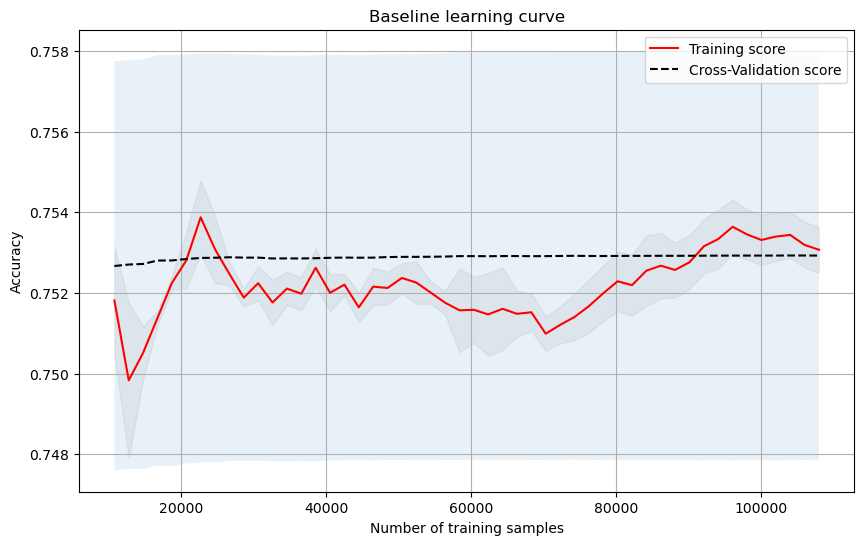

In [14]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="grey")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.plot(train_sizes, train_mean, color="r", label="Training score")
plt.plot(train_sizes, test_mean, '--', color="black", label="Cross-Validation score")
plt.title("Baseline learning curve")
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [15]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers):
        super(DNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(hidden_size, 1))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [19]:
def train_model (optim, results, epochs,y_train, y_test):
    y_train = np.reshape(y_train, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))

    x_train_tensor = torch.Tensor(X_train_normalized)
    y_train_tensor = torch.Tensor(y_train)
    x_test_tensor = torch.Tensor(X_test_normalized)
    y_test_tensor = torch.Tensor(y_test)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=64)

    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=64)

    layers = [1, 5, 25]
    learning_rates = [0.001, 0.01, 0.1]
    loss_fn = nn.MSELoss()
    for lr in learning_rates:
        for h_l in layers:
            key = f'DNN {h_l} hidden layer, {optim}, LR = {lr}'
            print(key)
            model = DNN(10, 8, h_l)
            optimizer = optim(model.parameters(), lr=lr)
            train_mse_values = []
            test_mse_values = []
            train_r2_scores_values = []
            test_r2_scores_values = []
            train_mapes_values = []
            test_mapes_values = []
            for epoch in range(epochs):
                for i, data in enumerate(train_dataloader, 0):
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                with torch.no_grad():
                    train_outputs = model(x_train_tensor)
                    train_loss = loss_fn(train_outputs, y_train_tensor).item()
                    train_r2 = r2_score(y_train_tensor, train_outputs)
                    train_mape = mean_absolute_percentage_error(y_train_tensor, train_outputs) * 100
                    train_mse_values.append(train_loss)
                    train_r2_scores_values.append(train_r2)
                    train_mapes_values.append(train_mape)

                with torch.no_grad():
                    test_outputs = model(x_test_tensor)
                    test_loss = loss_fn(test_outputs, y_test_tensor).item()
                    test_r2 = r2_score(y_test_tensor, test_outputs)
                    test_mape = mean_absolute_percentage_error(y_test_tensor, test_outputs) * 100
                    test_mse_values.append(test_loss)
                    test_r2_scores_values.append(test_r2)
                    test_mapes_values.append(test_mape)

                print(f'[epoch: {epoch + 1}] Train Loss: {train_loss}, Train R2: {train_r2}, Train MAPE: {train_mape} %')
                print(f'[epoch: {epoch + 1}] Test Loss: {test_loss}, Test R2: {test_r2}, Test MAPE: {test_mape} %')

            results[key] = {
                'train_losses': train_mse_values,
                'test_losses': test_mse_values,
                'train_r2_scores': train_r2_scores_values,
                'test_r2_scores': test_r2_scores_values,
                'train_mape_scores': train_mapes_values,
                'test_mape_scores': test_mapes_values
            }

    return results


In [20]:
def plot_metrics(key, results):
    train_r2 = results[key]['train_r2_scores']
    test_r2 = results[key]['test_r2_scores']
    train_mape = results[key]['train_mape_scores']
    test_mape = results[key]['test_mape_scores']
    train_mse = results[key]['train_losses']
    test_mse = results[key]['test_losses']
    epochs = range(1, len(train_r2) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_r2, label='Train R2 Score')
    plt.plot(epochs, test_r2, label='Test R2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.title('R2 Score')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_mape, label='Train MAPE')
    plt.plot(epochs, test_mape, label='Test MAPE')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.title('Mean Absolute Percentage Error (MAPE)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_mse, label='Train MSE')
    plt.plot(epochs, test_mse, label='Test MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error (MSE)')
    plt.legend()

    plt.tight_layout()
    plt.suptitle(key, y=1.1)  
    #plt.savefig(f"C:\\Users\\sindr\\Desktop\\{key}.png") 
    plt.show()


In [21]:
results_adam = {}
train_model(Adam, results_adam, 50, y_train, y_test)

DNN 1 hidden layer, <class 'torch.optim.adam.Adam'>, LR = 0.001
[epoch: 1] Train Loss: 4.65553092956543, Train R2: 0.8047400651588408, Train MAPE: 14.165027439594269 %
[epoch: 1] Test Loss: 4.62092924118042, Test R2: 0.8048623095633631, Test MAPE: 14.171229302883148 %
[epoch: 2] Train Loss: 3.007815361022949, Train R2: 0.873847717305613, Train MAPE: 11.42977923154831 %
[epoch: 2] Test Loss: 2.9887442588806152, Test R2: 0.8737880131740423, Test MAPE: 11.410605162382126 %
[epoch: 3] Train Loss: 2.0246894359588623, Train R2: 0.915081492214112, Train MAPE: 10.0258469581604 %
[epoch: 3] Test Loss: 2.0221710205078125, Test R2: 0.9146055317199582, Test MAPE: 10.086170583963394 %
[epoch: 4] Train Loss: 1.6868301630020142, Train R2: 0.9292518125867455, Train MAPE: 9.051451832056046 %
[epoch: 4] Test Loss: 1.691756010055542, Test R2: 0.928558668728993, Test MAPE: 9.110458940267563 %
[epoch: 5] Train Loss: 1.519811987876892, Train R2: 0.9362568074467006, Train MAPE: 8.203530311584473 %
[epoch: 5]

{"DNN 1 hidden layer, <class 'torch.optim.adam.Adam'>, LR = 0.001": {'train_losses': [4.65553092956543,
   3.007815361022949,
   2.0246894359588623,
   1.6868301630020142,
   1.519811987876892,
   1.4551180601119995,
   1.4200680255889893,
   1.3955132961273193,
   1.3756961822509766,
   1.3608273267745972,
   1.3520454168319702,
   1.3470239639282227,
   1.3436163663864136,
   1.3407973051071167,
   1.3391302824020386,
   1.3372714519500732,
   1.3355523347854614,
   1.3343627452850342,
   1.333540678024292,
   1.3328185081481934,
   1.3327244520187378,
   1.3324108123779297,
   1.3320648670196533,
   1.3317066431045532,
   1.3312264680862427,
   1.3309965133666992,
   1.3305758237838745,
   1.3302981853485107,
   1.3299225568771362,
   1.329615831375122,
   1.329444169998169,
   1.3292315006256104,
   1.3290461301803589,
   1.3288075923919678,
   1.3286359310150146,
   1.3284430503845215,
   1.3284021615982056,
   1.3282642364501953,
   1.328131914138794,
   1.3280229568481445,
   1.

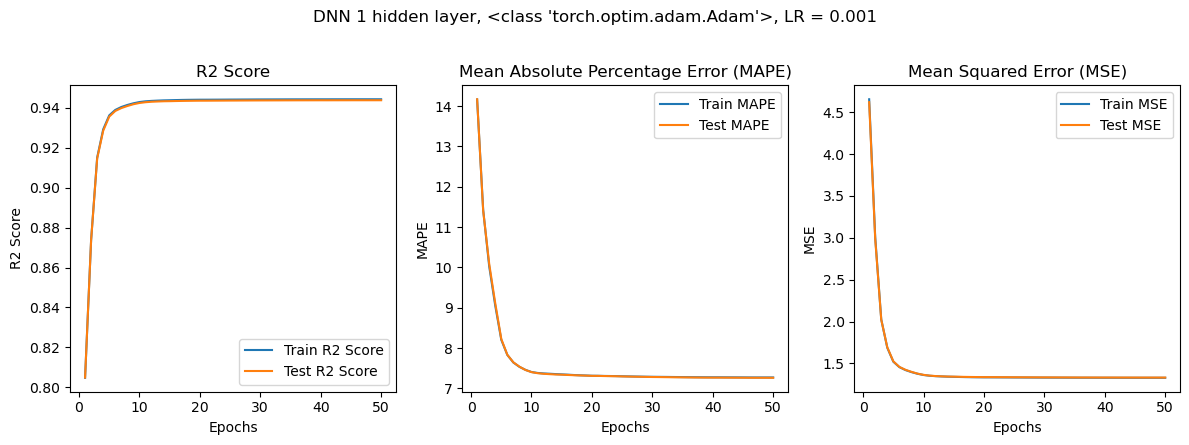

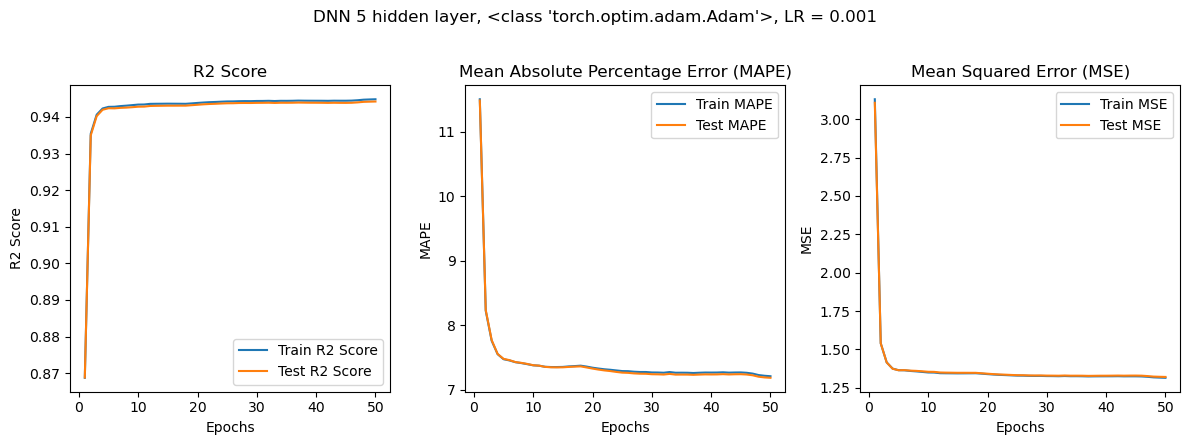

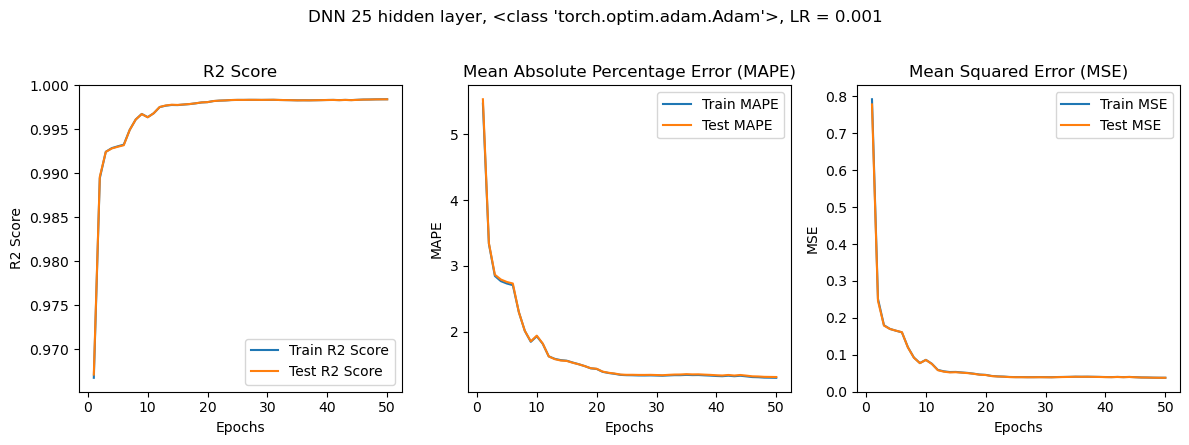

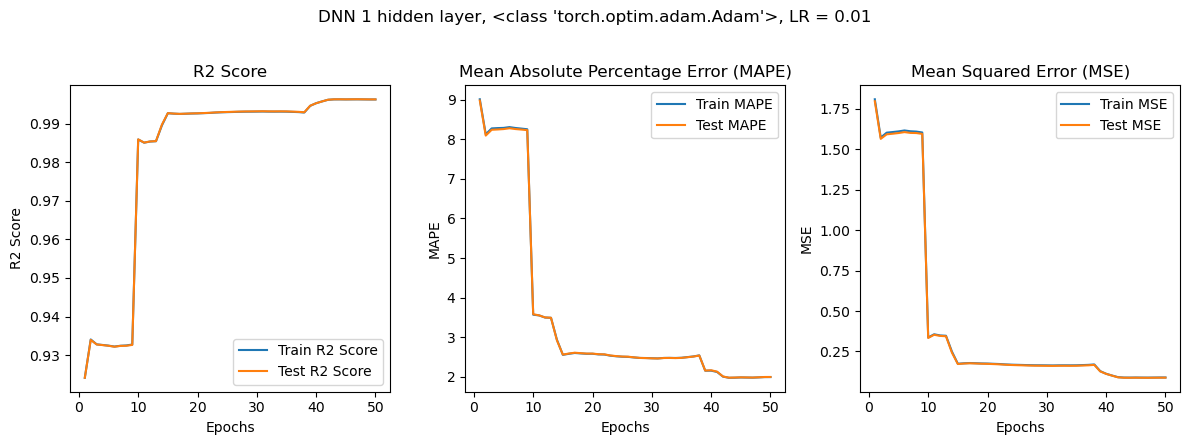

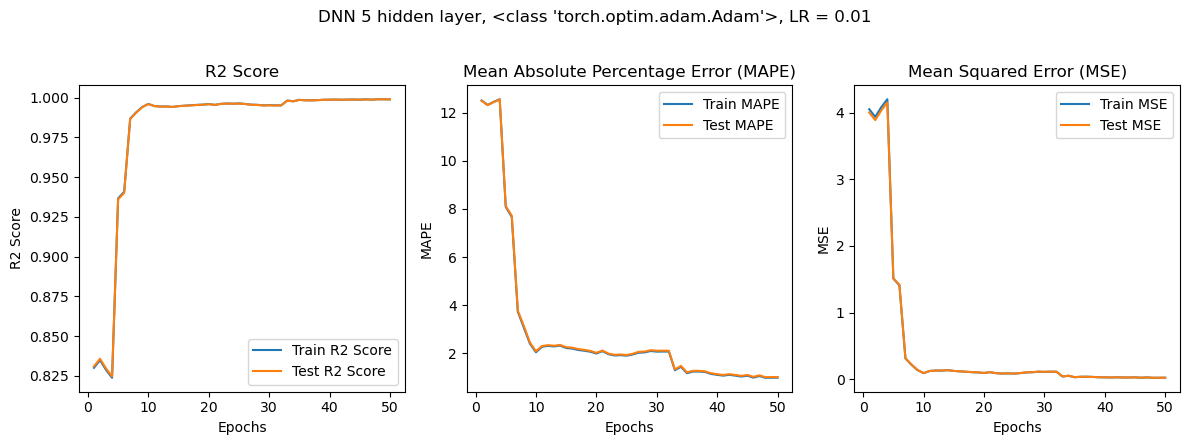

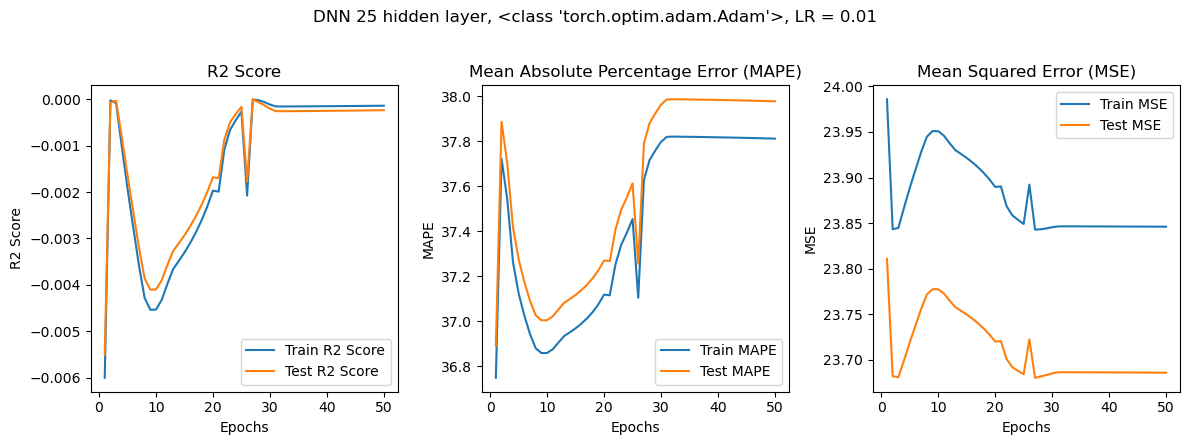

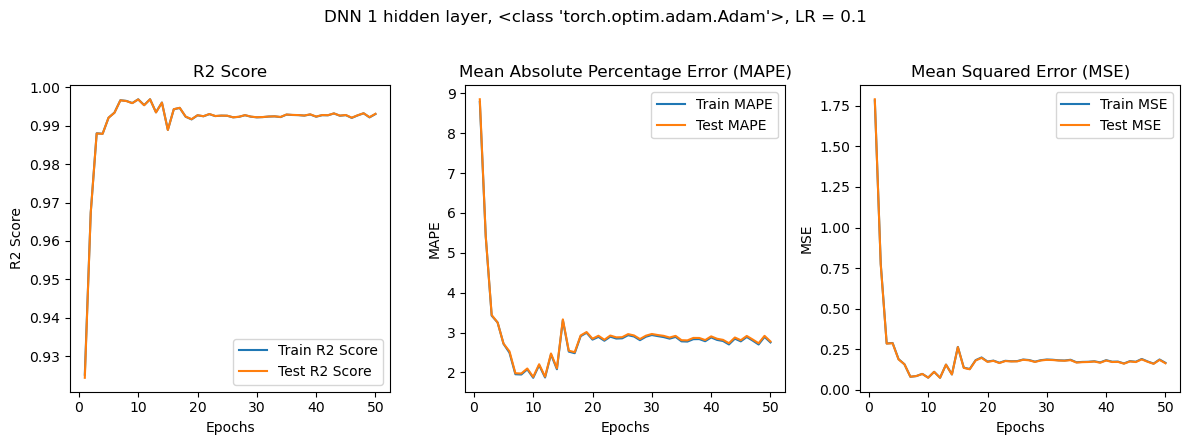

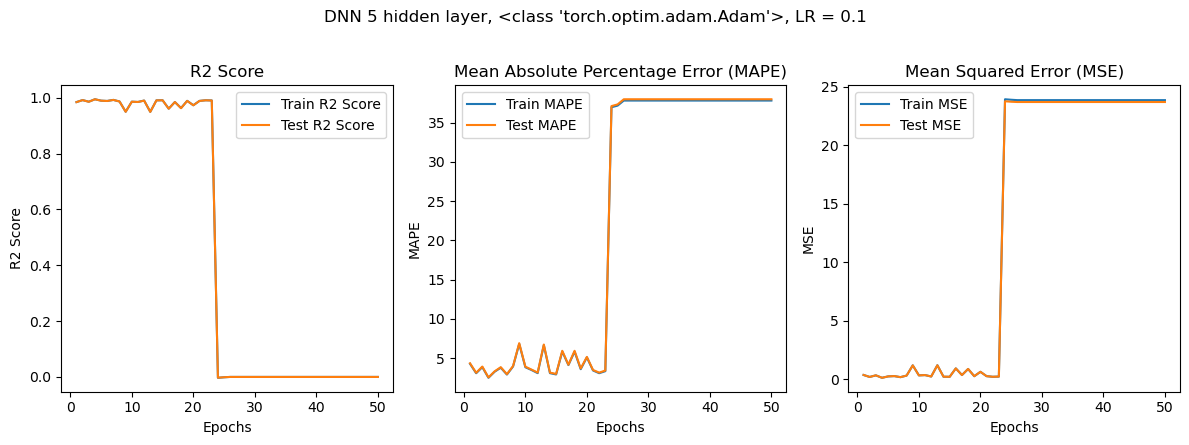

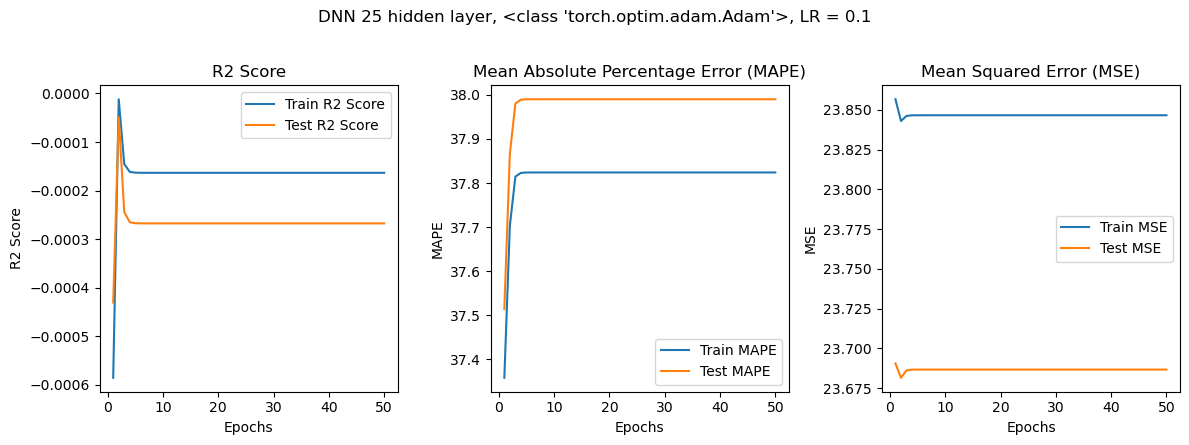

In [22]:
for key in results_adam:
    plot_metrics(key, results_adam)

In [23]:
results_rms = {}
train_model(RMSprop, results_rms, 50, y_train, y_test)

DNN 1 hidden layer, <class 'torch.optim.rmsprop.RMSprop'>, LR = 0.001
[epoch: 1] Train Loss: 4.386664390563965, Train R2: 0.8160167140000126, Train MAPE: 13.524620234966278 %
[epoch: 1] Test Loss: 4.345608711242676, Test R2: 0.8164888439184215, Test MAPE: 13.546538352966309 %
[epoch: 2] Train Loss: 3.9845738410949707, Train R2: 0.8328810011339164, Train MAPE: 12.414500117301941 %
[epoch: 2] Test Loss: 3.9571332931518555, Test R2: 0.83289379974237, Test MAPE: 12.425034493207932 %
[epoch: 3] Train Loss: 3.885159492492676, Train R2: 0.837050588431794, Train MAPE: 12.078619003295898 %
[epoch: 3] Test Loss: 3.860614061355591, Test R2: 0.8369697367472925, Test MAPE: 12.079577893018723 %
[epoch: 4] Train Loss: 3.845816135406494, Train R2: 0.8387007095626839, Train MAPE: 11.94327101111412 %
[epoch: 4] Test Loss: 3.819380521774292, Test R2: 0.8387109944519945, Test MAPE: 11.931774020195007 %
[epoch: 5] Train Loss: 3.8124613761901855, Train R2: 0.8400996447421551, Train MAPE: 11.853713542222977 

{"DNN 1 hidden layer, <class 'torch.optim.rmsprop.RMSprop'>, LR = 0.001": {'train_losses': [4.386664390563965,
   3.9845738410949707,
   3.885159492492676,
   3.845816135406494,
   3.8124613761901855,
   3.1304023265838623,
   1.6249161958694458,
   1.4532606601715088,
   1.4337639808654785,
   1.413475513458252,
   1.3919167518615723,
   1.3742085695266724,
   1.3621381521224976,
   1.3552203178405762,
   1.354527473449707,
   1.3538271188735962,
   1.352266788482666,
   1.3514176607131958,
   1.3507038354873657,
   1.3499834537506104,
   1.3492298126220703,
   1.348675012588501,
   1.3484320640563965,
   1.3492435216903687,
   1.3488954305648804,
   1.348551869392395,
   1.3484044075012207,
   1.3479958772659302,
   1.3477225303649902,
   1.3474557399749756,
   1.3469830751419067,
   1.3467695713043213,
   1.3464747667312622,
   1.3461946249008179,
   1.345995306968689,
   1.3459627628326416,
   1.3458489179611206,
   1.3456677198410034,
   1.345523476600647,
   1.3455003499984741,
 

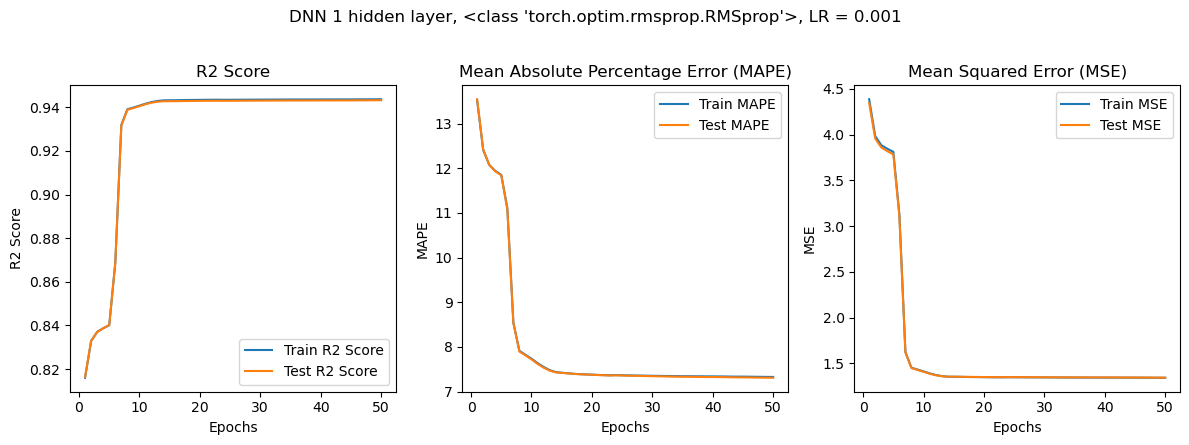

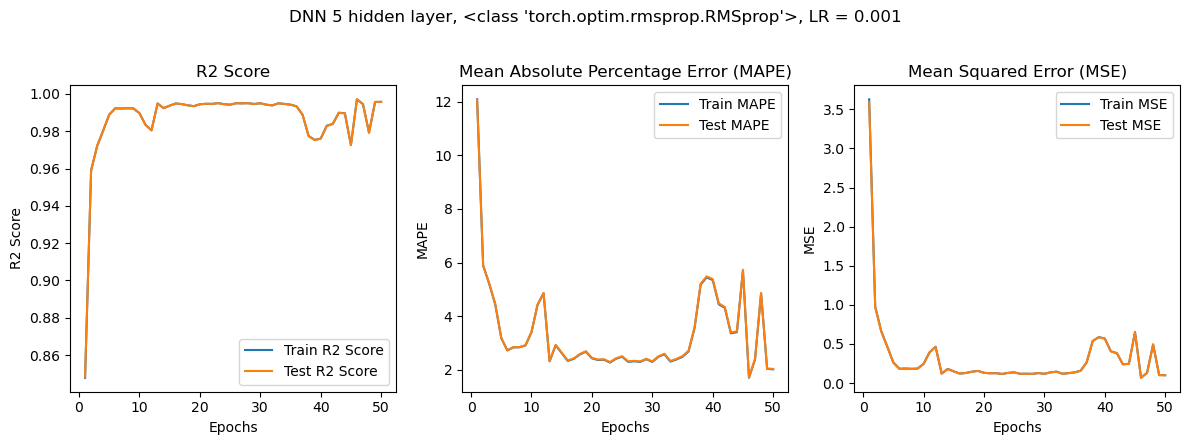

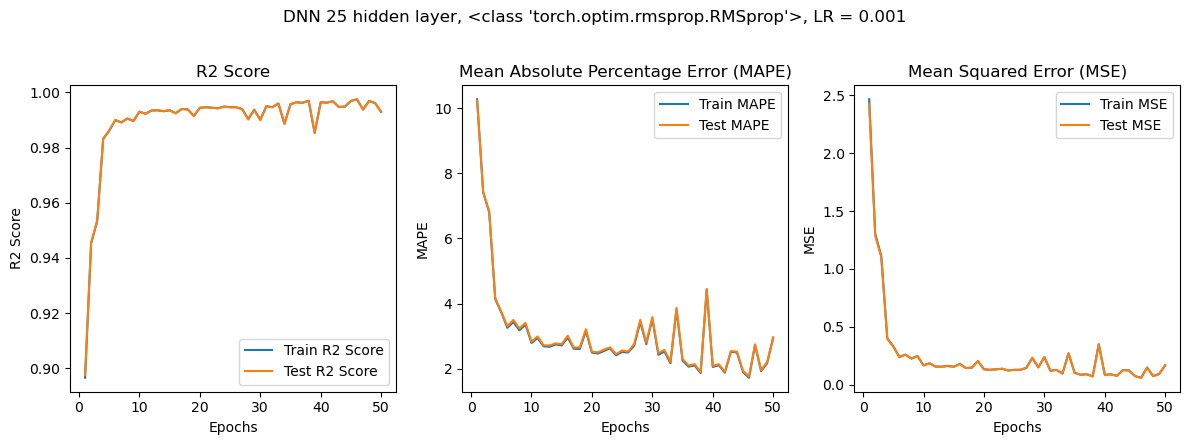

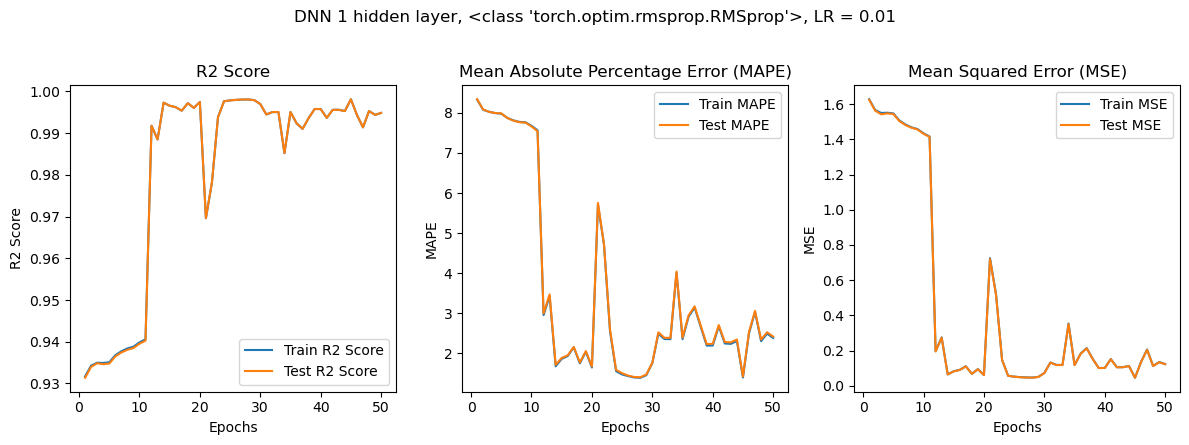

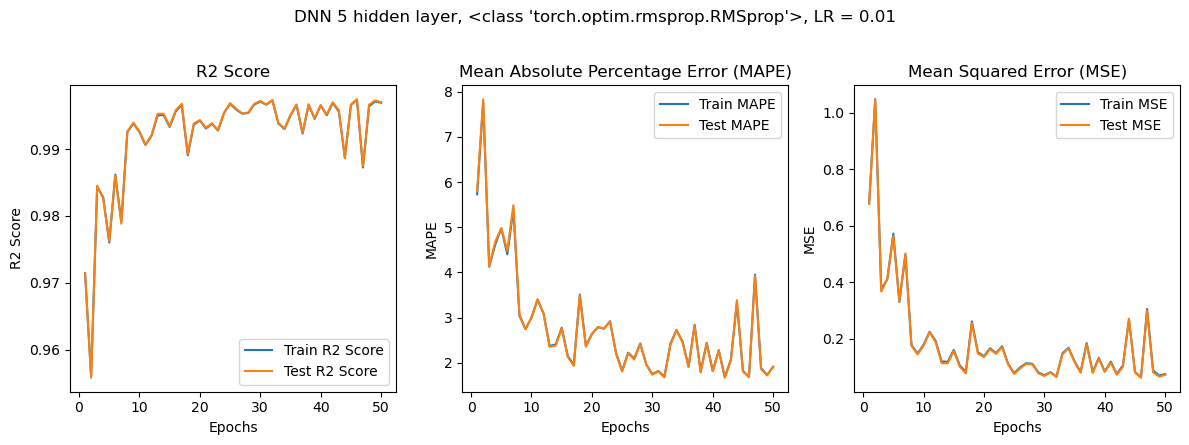

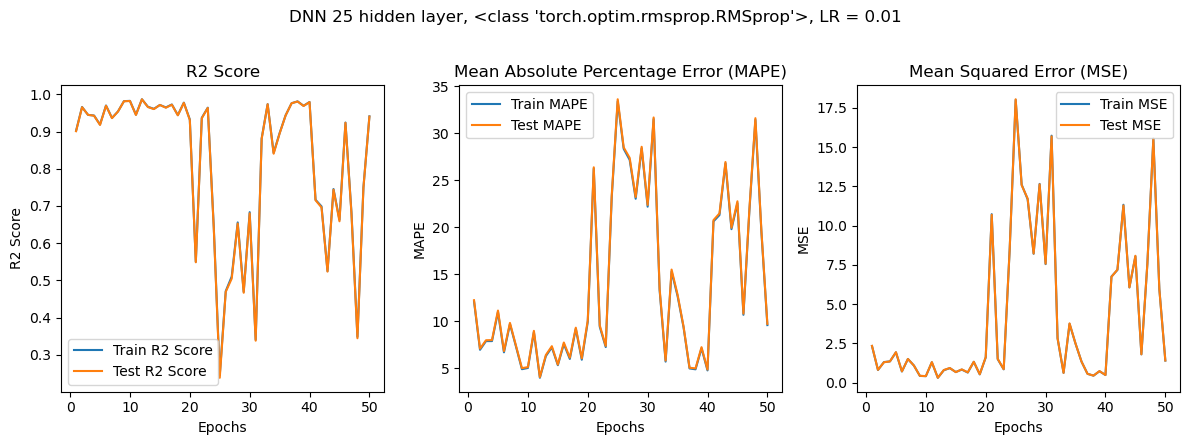

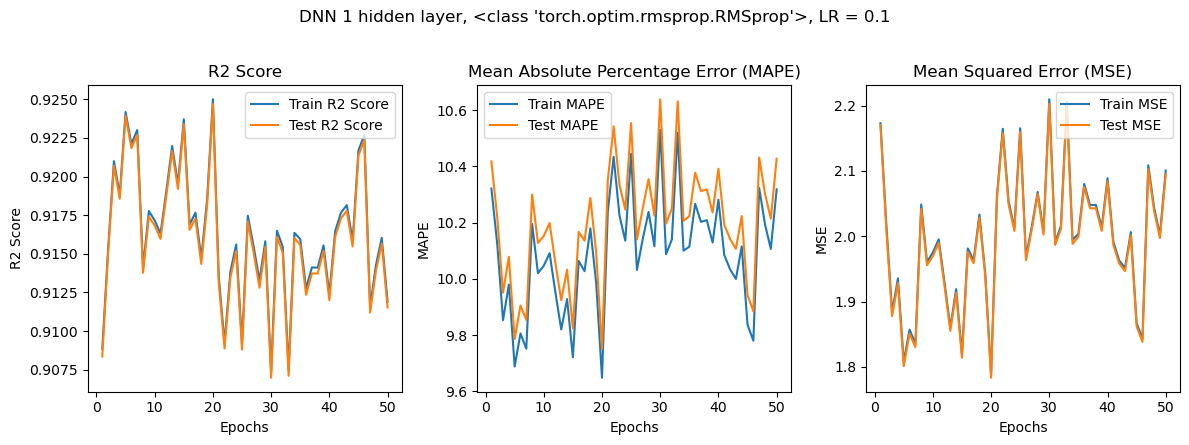

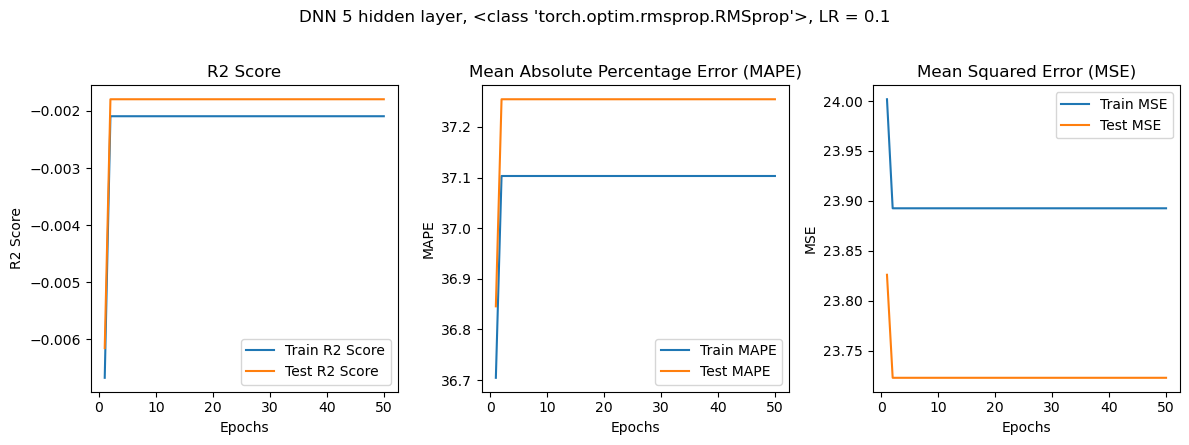

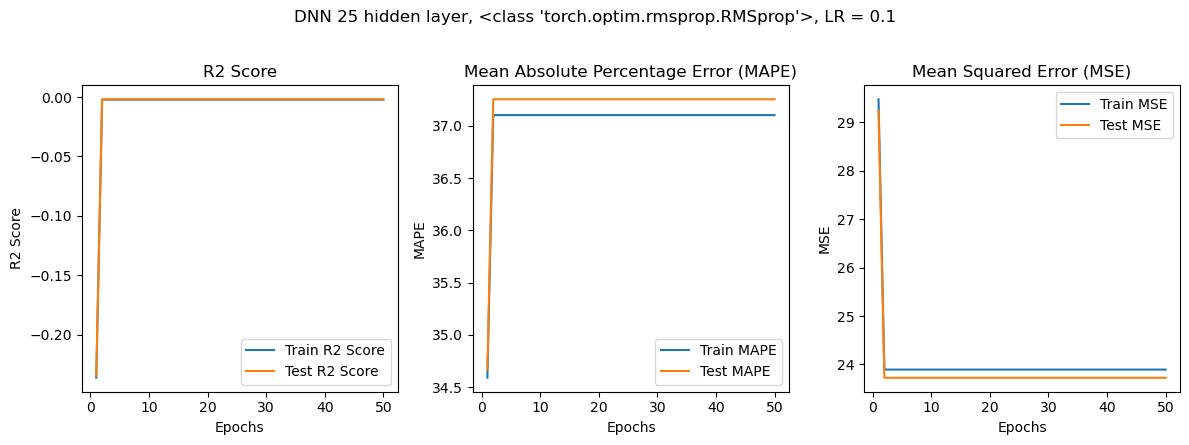

In [24]:
for key in results_rms:
    plot_metrics(key, results_rms)

In [25]:
results_sgd = {}
train_model(SGD, results_sgd, 50, y_train, y_test)

DNN 1 hidden layer, <class 'torch.optim.sgd.SGD'>, LR = 0.001
[epoch: 1] Train Loss: 3.030860424041748, Train R2: 0.8728811711615482, Train MAPE: 10.658209025859833 %
[epoch: 1] Test Loss: 2.9855945110321045, Test R2: 0.873921024542425, Test MAPE: 10.640675574541092 %
[epoch: 2] Train Loss: 2.8747832775115967, Train R2: 0.8794272735929127, Train MAPE: 10.22765040397644 %
[epoch: 2] Test Loss: 2.8284401893615723, Test R2: 0.880557507990094, Test MAPE: 10.208985954523087 %
[epoch: 3] Train Loss: 1.9695976972579956, Train R2: 0.9173921227474797, Train MAPE: 9.164568781852722 %
[epoch: 3] Test Loss: 1.9499714374542236, Test R2: 0.9176544564746666, Test MAPE: 9.177505224943161 %
[epoch: 4] Train Loss: 0.8989140391349792, Train R2: 0.9622981958514812, Train MAPE: 6.223627552390099 %
[epoch: 4] Test Loss: 0.8912508487701416, Test R2: 0.9623632775612545, Test MAPE: 6.282448768615723 %
[epoch: 5] Train Loss: 0.5775181651115417, Train R2: 0.9757780207301338, Train MAPE: 5.159664154052734 %
[epoc

{"DNN 1 hidden layer, <class 'torch.optim.sgd.SGD'>, LR = 0.001": {'train_losses': [3.030860424041748,
   2.8747832775115967,
   1.9695976972579956,
   0.8989140391349792,
   0.5775181651115417,
   0.533693790435791,
   0.513982892036438,
   0.4968966245651245,
   0.48138192296028137,
   0.46713489294052124,
   0.45454609394073486,
   0.4436243772506714,
   0.434541791677475,
   0.42721474170684814,
   0.42120102047920227,
   0.41602838039398193,
   0.4114120304584503,
   0.40700840950012207,
   0.40253573656082153,
   0.3976950943470001,
   0.3926404118537903,
   0.38701131939888,
   0.3809009790420532,
   0.3738558888435364,
   0.3647906184196472,
   0.3542046844959259,
   0.34390121698379517,
   0.3326457142829895,
   0.3200955092906952,
   0.30600038170814514,
   0.29046913981437683,
   0.27419987320899963,
   0.25777143239974976,
   0.24210183322429657,
   0.22776402533054352,
   0.21447356045246124,
   0.2013719528913498,
   0.188435360789299,
   0.17827676236629486,
   0.1716242

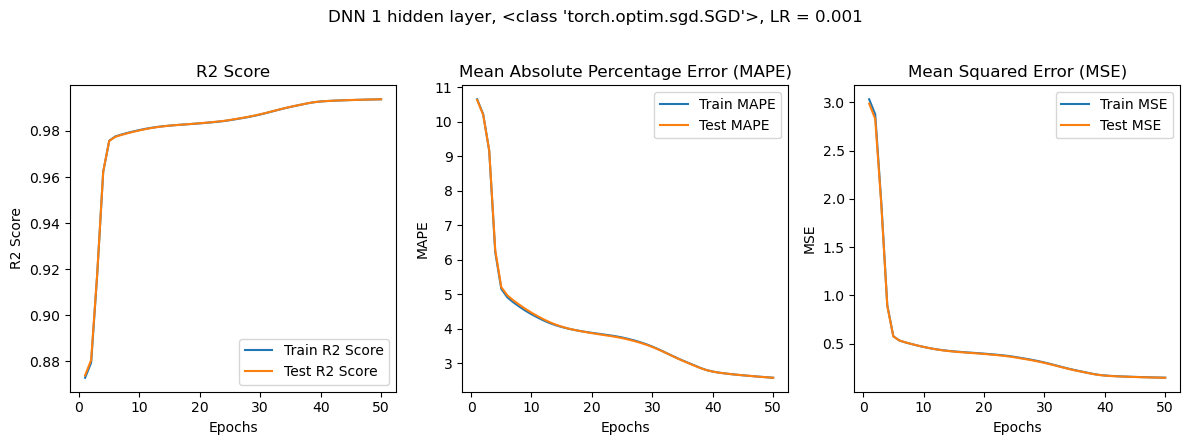

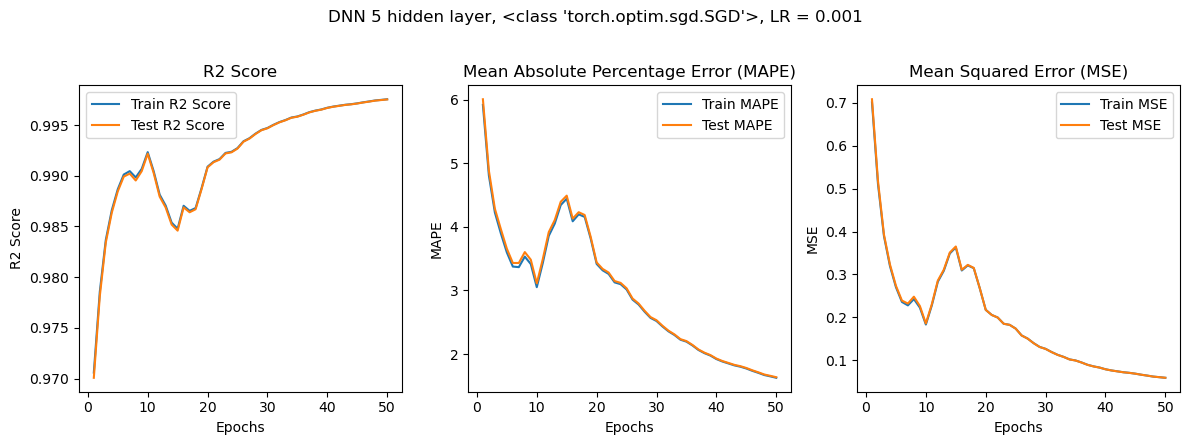

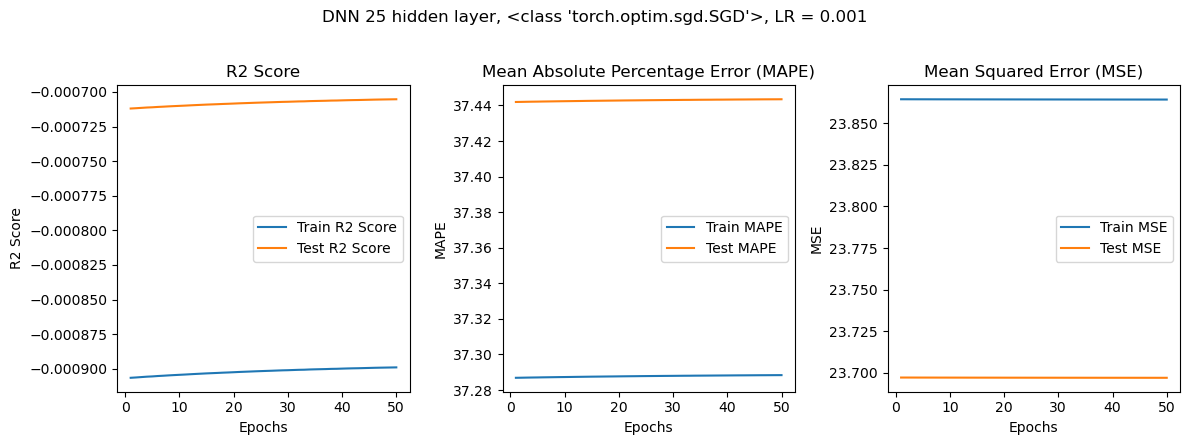

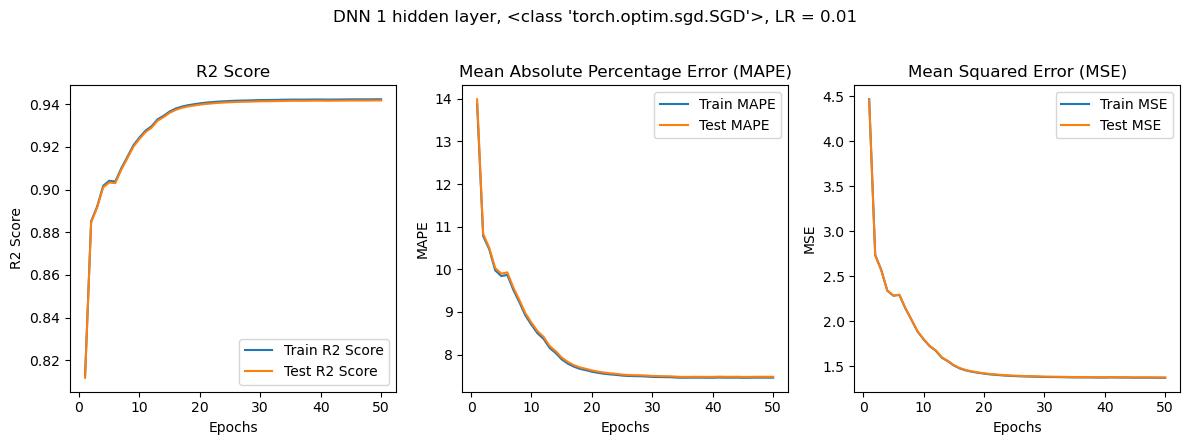

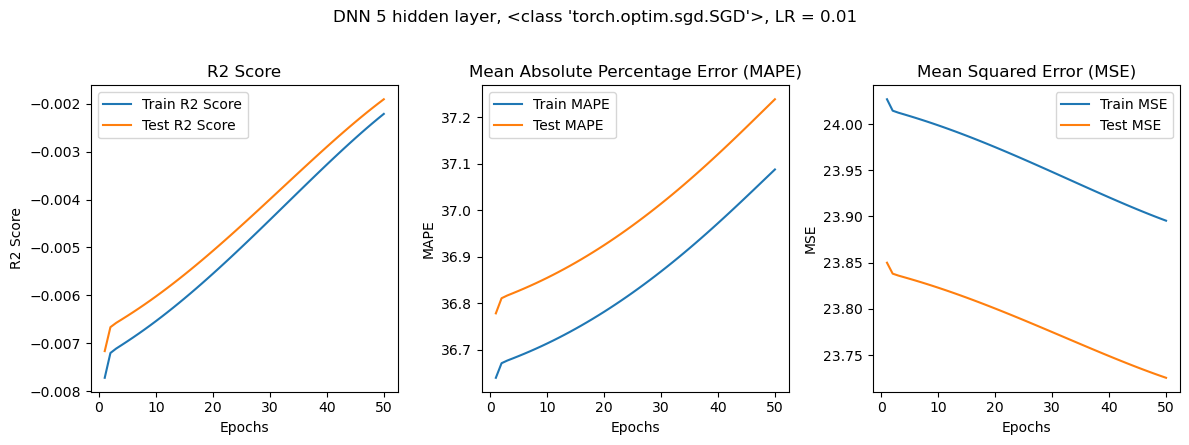

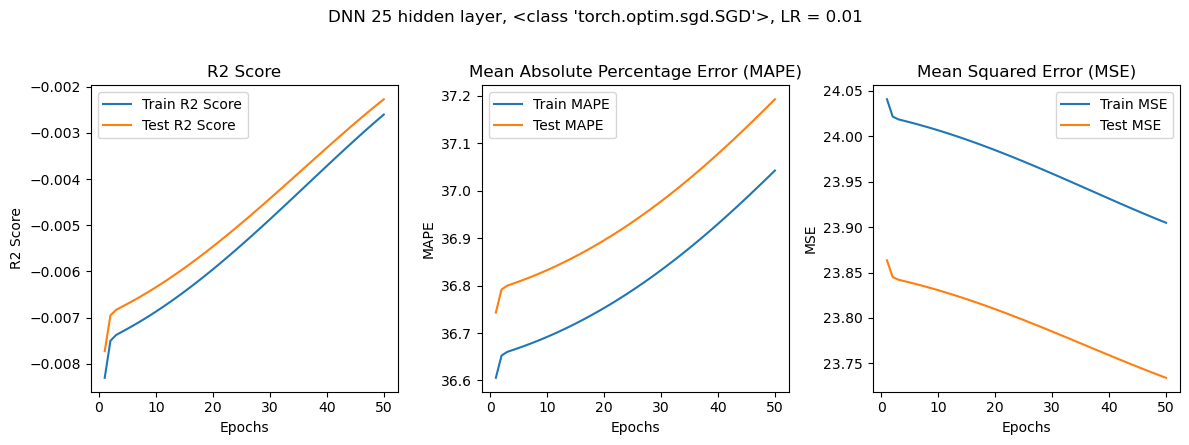

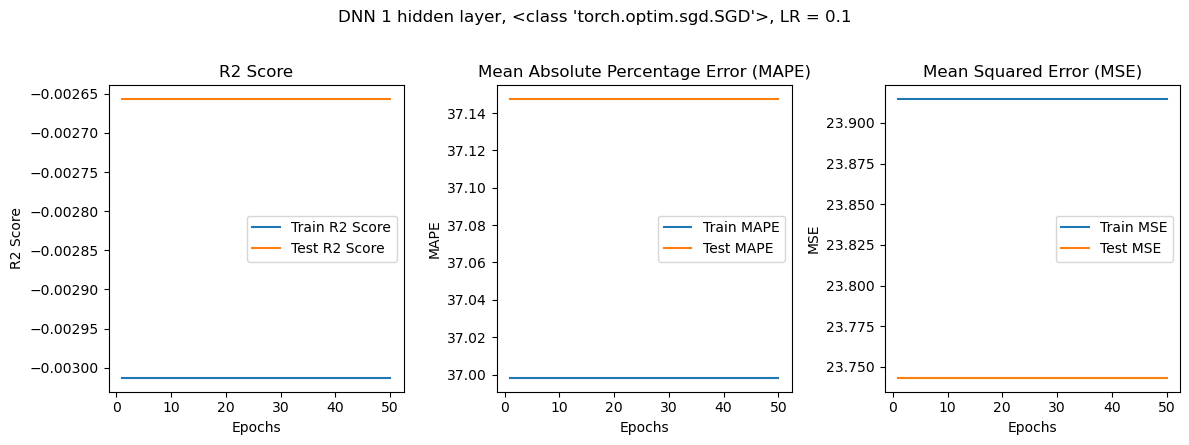

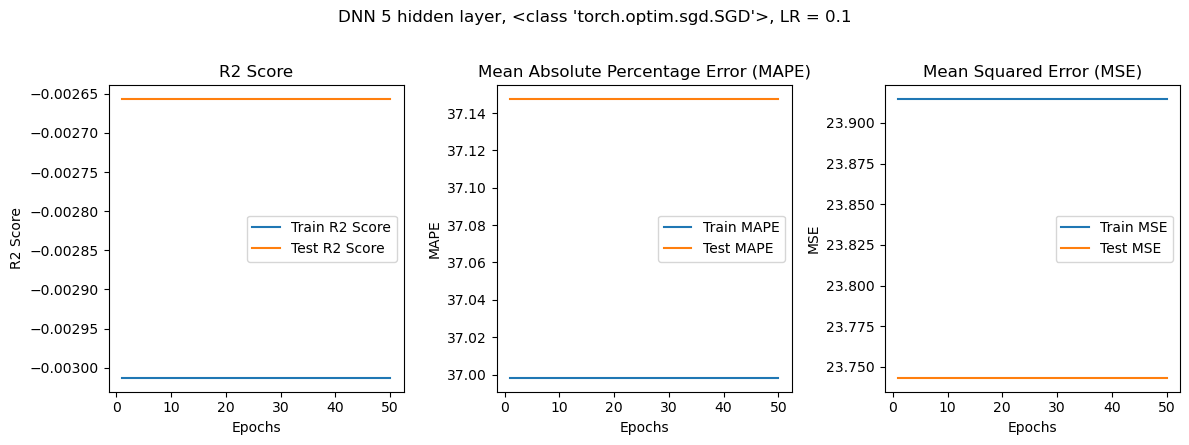

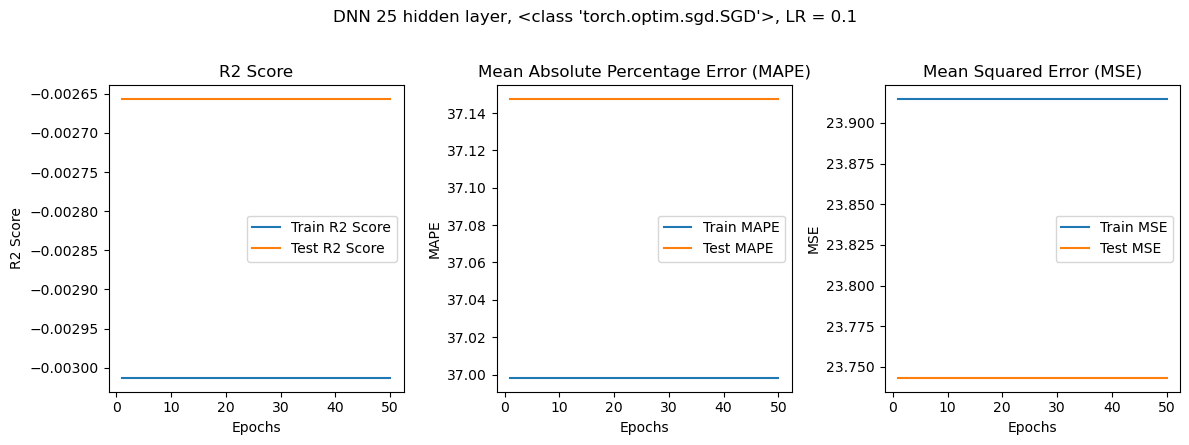

In [26]:
for key in results_sgd:
    plot_metrics(key, results_sgd)

1. What models and combinations of hyper-parameters worked best? Why?
2. Influence of optimizer?
3. Influence of learning rate?
4. Influence of DNN architecture (number of layers)?
5. Influence of data distribution (linear or non-linear?)


One big answer: В цій лабораторній роботі я натренувала нейронку з такими параметрами:
   - к-сть hidden layers: 1, 5, 25
   - learig rates: 0.1, 0.01, 0.001
   - оптимізатори: Adam, SGD, RMSprop
   - к-сть епохів: 50
   - ксть нейронів у hidden layer: 8
та можу зробити такі висновки:

1. В залежності від вибраного оптимізатора, learning rate та к-сть hidden layers результати варіювались у таких межах:
    - MSE: ~0.0375 у найкращих випадках  та до ~23.84 у найгірших 
    - R2 score: ~0.997 (близько 1) у найкращих випадках та до -0.001906 у найгірших 
    - MAPE: ~1.014 % у найкращих випадках  та до ~38 % у найгірших 
 
З графіків видно, що найкращі результати я отримала при оптимізаторі ADAM а найгірші при Стохастичному градієнтному спуску. Припускаю, що тому, що ADAM адапивний і краще уникає проблеми, такі як "застрягання" в локальних мінімумах або "вибухаючі" градієнти.

2. Learning rate також вплинув на навчання, адже при великоу кроці 0.1 нейронка взагалі не вчиться та видає погані результати (Test MSE: 23.74327278137207, Test R2: -0.002657074600792342, Test MAPE: 37.14736998081207 %/ Train MSE: 23.914566040039062, Train R2: -0.003012749872082443, Train MAPE: 36.998265981674194 %). Особливо, для SGD, або при великій к-сті hidden layerів для ADAM, RMSprop

3. У моєму випадку найгірші результати були при 25 hidden layers, а найкращі при 1 (при 5 буль теж непогані, але залежить від оптимізатора та lr). 

Як висновок, усі 3 параметри впливають на навчання мережі, тому між ими потрібно знайти баланс. У моєму випадку найкращі результати були при таких комбінаціях:
   - DNN 1 hidden layer, Adam, LR = 0.001
   - DNN 5 hidden layer, Adam, LR = 0.001
   - DNN 1 hidden layer, RMSprop, LR = 0.001
   - DNN 5 hidden layer, RMSprop, LR = 0.001
   - DNN 25 hidden layer, RMSprop, LR = 0.001
   - DNN 1 hidden layer, Adam, LR = 0.1
   - DNN 1 hidden layer, SGD, LR = 0.001 (не найкраще, але порівняно з іншими, набагато краще)

Також варто уточнити, що при створенні датасету я не включала параметр random_state, тому при кожному запуску результати будуть інші